In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from pylab import mpl # 设置中文字体
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

In [22]:
# 1. 使用sklearn生成合成分类数据集
# n_samples: 样本数量 | n_features: 特征数量 | n_informative: 有效特征数量
# n_redundant: 冗余特征数量 | n_classes: 类别数 | weights: 类别权重（模拟类别不平衡）
# flip_y: 标签随机噪声比例 | random_state: 随机种子
X, y = make_classification(
    n_samples=500,
    n_features=20,
    n_informative=5,
    n_redundant=5,
    n_classes=3,
    weights=[0.5, 0.3, 0.2],
    flip_y=0.05,
    random_state=42
)

In [23]:
# 将数据转换为PyTorch张量
X = torch.from_numpy(X).float()  # 特征矩阵转换为浮点型张量
y = torch.from_numpy(y).long()   # 标签转换为长整型张量

In [24]:
X.shape, y.shape  # 输出特征和标签的形状

(torch.Size([500, 20]), torch.Size([500]))

In [25]:
# 分割数据集为训练集和验证集（80-20比例）
split_idx = int(0.8 * len(y))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

In [26]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape  # 输出训练集和验证集的形状

(torch.Size([400, 20]),
 torch.Size([400]),
 torch.Size([100, 20]),
 torch.Size([100]))

In [27]:
# 创建PyTorch数据集和数据加载器
batch_size = 64
train_ds = TensorDataset(X_train, y_train)  # 训练数据集
val_ds   = TensorDataset(X_val,   y_val)    # 验证数据集
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)  # 训练数据加载器（打乱顺序）
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2) # 验证数据加载器

In [28]:
# 2. 定义多层感知机（MLP）模型
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes):
        """初始化MLP
        Args:
            input_dim (int): 输入特征维度
            hidden_dims (list): 隐藏层维度列表（例如[64, 32]表示两个隐藏层）
            num_classes (int): 输出类别数
        """
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims  # 构建各层维度（输入层+隐藏层）
        # 循环添加隐藏层：线性层 + ReLU激活
        for in_dim, out_dim in zip(dims[:-1], dims[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.ReLU())
        # 添加输出层（无激活函数）
        layers.append(nn.Linear(dims[-1], num_classes))
        self.net = nn.Sequential(*layers) # 使用nn.Sequential将所有层组合成一个模型
    
    def forward(self, x):
        """前向传播"""
        return self.net(x)

In [29]:
# 实例化模型并移至GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim=20, hidden_dims=[64, 32], num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Adam优化器

Epoch  1: Train Loss=1.0382, Val Loss=0.9794, Val Acc=0.5900
Epoch  2: Train Loss=0.9829, Val Loss=0.9286, Val Acc=0.6200
Epoch  3: Train Loss=0.9374, Val Loss=0.8855, Val Acc=0.6300
Epoch  4: Train Loss=0.8966, Val Loss=0.8460, Val Acc=0.6300
Epoch  5: Train Loss=0.8570, Val Loss=0.8052, Val Acc=0.6600
Epoch  6: Train Loss=0.8140, Val Loss=0.7634, Val Acc=0.6700
Epoch  7: Train Loss=0.7729, Val Loss=0.7283, Val Acc=0.7100
Epoch  8: Train Loss=0.7327, Val Loss=0.6970, Val Acc=0.7200
Epoch  9: Train Loss=0.6961, Val Loss=0.6752, Val Acc=0.7300
Epoch 10: Train Loss=0.6644, Val Loss=0.6636, Val Acc=0.7300


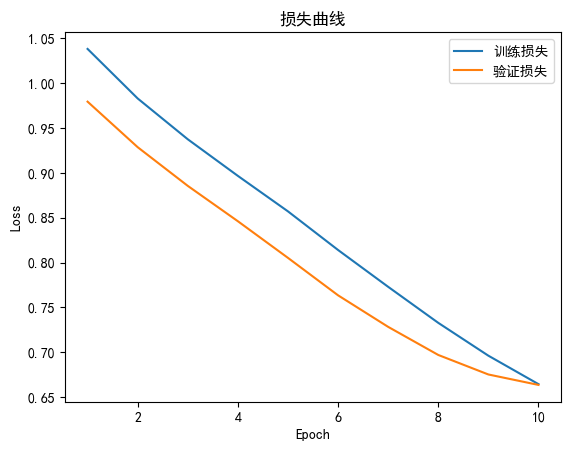

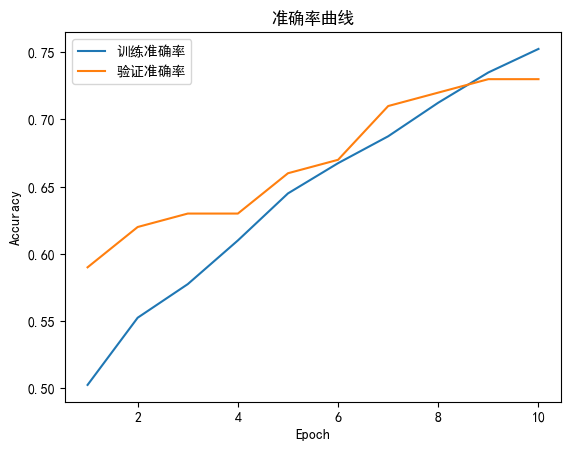

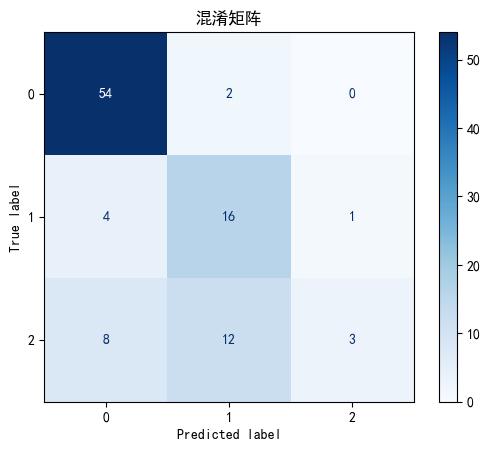

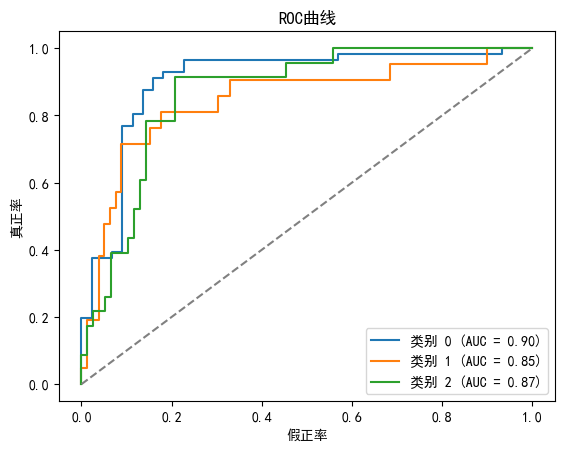

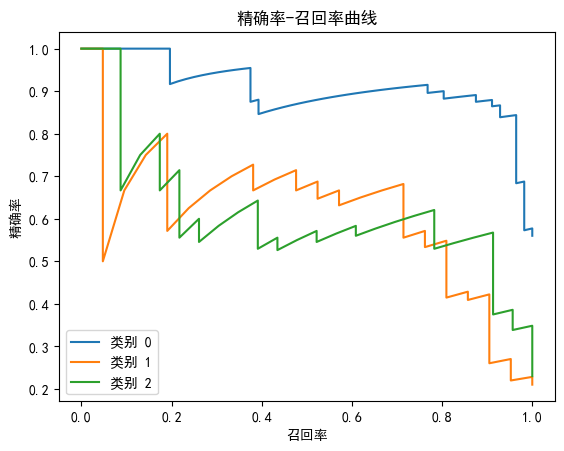

In [30]:
if __name__ == '__main__':
    # 3. 训练循环
    num_epochs = 10
    train_losses, val_losses = [], []  # 记录每个epoch的损失
    train_accs,   val_accs   = [], []  # 记录每个epoch的准确率
    
    for epoch in range(1, num_epochs + 1):
        # ---------- 训练阶段 ---------- 
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)  # 数据移至设备
            optimizer.zero_grad()                  # 清空梯度
            outputs = model(xb)                    # 前向传播
            loss = criterion(outputs, yb)          # 计算损失
            loss.backward()                        # 反向传播
            optimizer.step()                       # 参数更新
            
            # 累计统计信息
            running_loss += loss.item() * xb.size(0)
            preds = outputs.argmax(dim=1)          # 获取预测类别
            correct += (preds == yb).sum().item()  # 正确预测数
            total += yb.size(0)
        # 记录训练集平均损失和准确率
        train_losses.append(running_loss / total)
        train_accs.append(correct / total)

        # ---------- 验证阶段 ----------
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        all_probs, all_labels = [], []  # 收集所有预测概率和真实标签（用于后续评估）
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                val_loss += criterion(outputs, yb).item() * xb.size(0)
                
                # 计算预测概率（用于ROC/PR曲线）
                probs = torch.softmax(outputs, dim=1)
                all_probs.append(probs.cpu())       # 移至CPU并保存
                all_labels.append(yb.cpu())
                
                # 统计验证集准确率
                preds = outputs.argmax(dim=1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)
        # 记录验证集平均损失和准确率
        val_losses.append(val_loss / total)
        val_accs.append(correct / total)
        print(f"Epoch {epoch:2d}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}, Val Acc={val_accs[-1]:.4f}")

    # 4. 保存模型权重
    torch.save(model.state_dict(), "synthetic_classifier.pth")

    # 5. 可视化评估结果
    epochs = range(1, num_epochs + 1)
    
    # 绘制损失曲线
    plt.figure()
    plt.plot(epochs, train_losses, label="训练损失")
    plt.plot(epochs, val_losses,   label="验证损失")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("损失曲线")
    plt.legend()
    plt.show()

    # 绘制准确率曲线
    plt.figure()
    plt.plot(epochs, train_accs, label="训练准确率")
    plt.plot(epochs, val_accs,   label="验证准确率")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("准确率曲线")
    plt.legend()
    plt.show()

    # 合并验证集的预测结果
    y_all = torch.cat(all_labels).numpy()      # 真实标签
    probs_all = torch.cat(all_probs).numpy()   # 预测概率（每个类别的概率）
    preds_all = probs_all.argmax(axis=1)       # 预测类别（取最大概率）

    # 混淆矩阵
    cm = confusion_matrix(y_all, preds_all)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1,2])
    disp.plot(cmap="Blues")
    plt.title("混淆矩阵")
    plt.show()

    # 多类别ROC曲线（OvR策略）
    plt.figure()
    for i in range(3):  # 对每个类别分别绘制
        fpr, tpr, _ = roc_curve((y_all == i).astype(int), probs_all[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"类别 {i} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # 随机参考线
    plt.xlabel("假正率")
    plt.ylabel("真正率")
    plt.title("ROC曲线")
    plt.legend()
    plt.show()

    # 精确率-召回率曲线（各类别）
    plt.figure()
    for i in range(3):
        precision, recall, _ = precision_recall_curve((y_all == i).astype(int), probs_all[:, i])
        plt.plot(recall, precision, label=f"类别 {i}")
    plt.xlabel("召回率")
    plt.ylabel("精确率")
    plt.title("精确率-召回率曲线")
    plt.legend()
    plt.show()